# Imports


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib # Pour sauvegarder le modèle

# Loading Data and Initial checking

In [16]:
# Loading the house data
df = pd.read_csv('House-Data.csv')

# Let's see the first few rows
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Cleaning 

In [17]:
# Checking for any empty spots
print(df.isnull().sum())

# Checking for duplicates - sometimes data is entered twice
print("Duplicate rows:", df.duplicated().sum())

# Just in case, we drop duplicates
df = df.drop_duplicates()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
Duplicate rows: 0


# Dropping Useless Columns

In [18]:
# The ID and Date aren't going to help a math formula predict price
# 'yr_built' is useful, but the 'date' the house was sold is just a label here
df_cleaned = df.drop(['id', 'date'], axis=1)

# Let's see the new columns
df_cleaned.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Handling Outliers

In [19]:
# Some houses are millions of dollars and will mess up our KNN neighbors
# Let's remove the top 1% of outliers
upper_limit = df_cleaned['price'].quantile(0.99)
df_final = df_cleaned[df_cleaned['price'] <= upper_limit]

print(f"Removed houses over ${upper_limit:,.0f}")

Removed houses over $1,964,400


# Split

In [20]:
from sklearn.model_selection import train_test_split

# Defining X (everything except price) and y (price only)
X = df_final.drop('price', axis=1)
y = df_final['price']

# We split the data: 80% for training and 20% to test the model later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (17116, 18)
Testing set size: (4280, 18)


# Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

# Creating the scaler object
scaler = StandardScaler()

# We fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimization (Finding the best k)

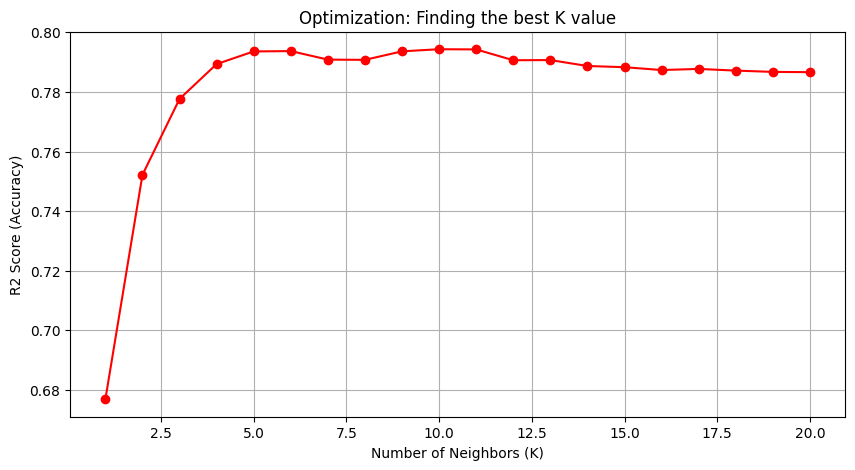

The best K value for this model is: 10


In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# We create a loop to test different K values
k_results = []

for k in range(1, 21):
    knn_test = KNeighborsRegressor(n_neighbors=k)
    knn_test.fit(X_train_scaled, y_train)
    predictions = knn_test.predict(X_test_scaled)
    score = r2_score(y_test, predictions)
    k_results.append(score)

# Let's plot the results to find the "peak"
plt.figure(figsize=(10,5))
plt.plot(range(1, 21), k_results, marker='o', color='red')
plt.title('Optimization: Finding the best K value')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('R2 Score (Accuracy)')
plt.grid(True)
plt.show()

# Find the exact best K
best_k = np.argmax(k_results) + 1
print(f"The best K value for this model is: {best_k}")

# Final Training and Saving

In [23]:
import joblib

# Training the final model
final_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
final_model.fit(X_train_scaled, y_train)

# Saving the model, the scaler, and the column names
joblib.dump(final_model, 'knn_house_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(list(X.columns), 'features.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
